In [1]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import pandas as pd
import os
from treys import Card
from termcolor import colored
from utils import eval_listof_games , debug_listof_games, save_results , load_results
import scipy

In [2]:
import skimage.io
import matplotlib.pyplot as plt
from skimage.segmentation import flood, flood_fill
from skimage import morphology
from skimage.morphology import closing, opening, disk, square
from skimage import filters
import cv2 as cv

In [3]:
from helper import *

%load_ext autoreload
%autoreload 2

Import all train data

In [19]:
path_data = 'data/train'
i = 0
file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
images = []

while os.path.exists(file):
    im = skimage.io.imread(file)
    images.append(im)
    i += 1
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")

Subsample to 2 images for now

## Segment image

In [6]:
""" GLOBAL CONSTANTS (SCOTCH MARKERS) """
P1 = [0.5, 0.875]
P2 = [0.122, 0.749]
P3 = [0.135, 0.308]
P4 = [0.54, 0.107]
C1 = [0.932, 0.227]
C2 = [0.932, 0.381]
C3 = [0.932, 0.535]
C4 = [0.932, 0.673]
C5 = [0.924, 0.811]
MARKERS = np.array([P1, P2, P3, P4,
                          C1, C2, C3, C4, C5])
CARD_DIM = [0.165, 0.118]

""" Use global constants in functions """

def find_markers_idx(image, MARKERS):
    table_dim = image.shape[:2]
    return (MARKERS * table_dim).astype(int)

def find_player_search_area(image, marker):
    # adapt search area to table size
    row, col = image.shape[:2]
    R, C = int(row/6), int(col/6)
    x1, x2, y1, y2 = marker[0]-R, marker[0]+R, marker[1]-C, marker[1]+C
    # return a crop on the image
    x1, x2 = np.clip([x1, x2], 0, row)
    y1, y2 = np.clip([y1, y2], 0, col)
    search_area = image[x1:x2, y1:y2]
    return search_area

def find_common_search_area(image, markers, CARD_DIM):
    """ Works but a bit edgy, would be better to rely on something else """
    # isolate a 1rst big search area in bottom 3rd of the image
    row, col = image.shape[:2]
    C = int((CARD_DIM[1]*col))
    start, end = markers[0,1]-C, markers[-1,1]+C
    big_area = image[int(2/3*row):row, start:end]
    """ FINALLY WE DONT CUT THE IMAGE HERE"""
    return big_area
    
    
#     # refine using edge detector and contours filtering
#     edges = edge_detector([big_area])[0]
#     contours = contours_by_img([edges])[0]
#     contours = filter_contours_by_size([contours], 100, 3000)[0]
#     start = np.min([np.min(contour[0,:]) for contour in contours])
#     end = np.max([np.max(contour[0,:]) for contour in contours])

#     # rescale image and divide in 5
#     big_area = big_area[:,start:end]
#     w = int(big_area.shape[1]/5)
#     cards = [big_area[ : , w*i : w*(1+i) ] for i in range(5)]
#     return cards

# standard procedure (works when contours are well defined)

In [20]:
test_image = images[2]

crop table and define markers on it

In [21]:
_, crop = cropping_routine(test_image)
markers = find_markers_idx(crop)
player_markers, common_markers = markers[:4], markers[4:]

isolate player areas

In [22]:
player_areas = []
for marker in player_markers:
    search_area = find_player_search_area(crop, marker)
    player_areas.append(search_area)

isolate common cards areas

In [23]:
common_areas = find_common_search_area(crop, common_markers)

(verify result)

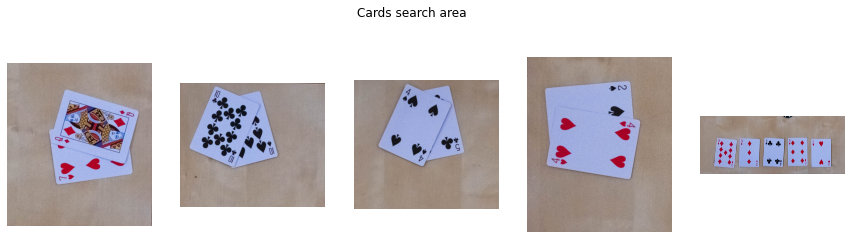

In [24]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize=(15,4))
for area, ax in zip(player_areas + [common_areas], axes.flatten()):
    #ax.scatter(603,587)
    #ax.scatter(826,545)
    ax.imshow(area)
    ax.axis('off')
fig.suptitle('Cards search area')
plt.show()

### contours from standard procedure

In [25]:
edges = edge_detector(player_areas)
contours = contours_by_img(edges)
filt_contours = filter_contours_by_size(contours, 69, 310) #value taken from setup_data notebook

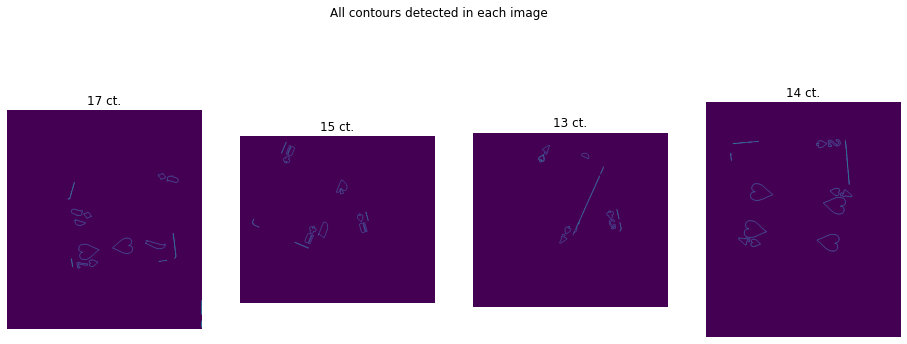

In [26]:
fig, axes = plt.subplots(ncols = 4, figsize=(16,15))
for ax, contours, image in zip(axes.flatten(), filt_contours, player_areas):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im)
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
fig.suptitle('All contours detected in each image', y = 0.7)
plt.show()

## prediction stuff (works when contours are well-defined)

In [27]:
n = 10
cards_comp_ct = [complex_contours(card_cont) for card_cont in filt_contours]
test_descr = [n_FT_descr(comp_ct, n) for comp_ct in cards_comp_ct]

In [28]:
test_3D_descr = []
for card_descr in test_descr:
    if len(card_descr)!=0:
        descr_1 = card_descr[:,1]
        descr_2 = card_descr[:,2]
        descr_3 = card_descr[:,3]
        descr_4 = card_descr[:,4]
        descr_5 = card_descr[:,5]
        descr_6 = card_descr[:,6]
        descr_7 = card_descr[:,7]
        descr_8 = card_descr[:,8]
        descr_9 = card_descr[:,9]
        card_contours_descr = np.vstack([descr_1,descr_2,descr_3,
                                         descr_4,descr_5,descr_6,
                                        descr_7,descr_8,descr_9]).T
    else: card_contours_descr = np.zeros(9)
    test_3D_descr.append(card_contours_descr)

In [29]:
GT_descr = np.load('GT_descr.npy', allow_pickle = True)

In [31]:
NUMBER_KEYS = np.array(['K', 'Q', 'J', '10', '9',
                        '8', '7', '6', '5', '4',
                                '3', '2', 'A'])
SYMBOL_KEYS = np.array(['C', 'S', 'D', 'H'])

for i in range(4):
    cards = player_pred(test_3D_descr[i], filt_contours[i], GT_descr, 4-i, NUMBER_KEYS, SYMBOL_KEYS)
    print(cards)

['7coeur', 'Qcarreau']
['10trèfle', '10pique']
['3pique', '10trèfle']
['4coeur', '2pique']


# trying stuff to make it work on all images

## Contours from card isolation procedure

In [32]:
test_images = [images[0], images[4], images[6], images[12]]

crop table and define markers on it

In [33]:
card_areas = []
for test_image in test_images:
    player_areas = []
    _, crop = cropping_routine(test_image)
    markers = find_markers_idx(crop)
    player_markers, common_markers = markers[:4], markers[4:]
    
    for marker in player_markers:
        search_area = find_player_search_area(crop, marker)
        player_areas.append(search_area)
    card_areas.append(player_areas)

In [34]:
card_areas = [area for player in card_areas for area in player]

In [23]:
#common_areas = find_common_search_area(crop, common_markers)

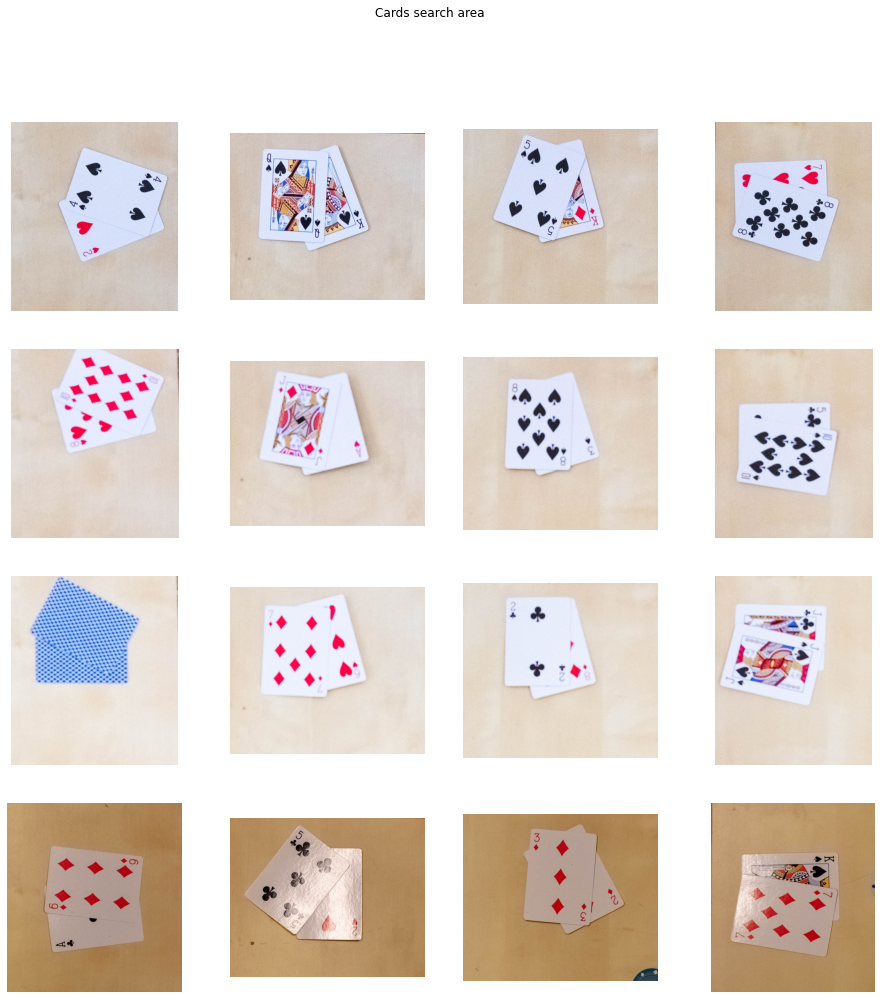

In [40]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize=(16,16))
for area, ax in zip(card_areas, axes.flatten()):
    ax.imshow(area)
    ax.axis('off')
fig.suptitle('Cards search area')
plt.show()

In [211]:
def isolate_card_feat(img):
    # threshold green channel for a better grayscale contrast
    # x = np.copy(img)
    # cond = x[:,:,1] < 222
    # x[cond] = 0
    
    # create the grayscale
    x = hist_eq(img)
    x = x[:,:,1]
    otsu = filters.threshold_otsu(x)
    x = (x < otsu).astype(int)
    x = skimage.segmentation.flood_fill(x, (0,0), 0, tolerance = 0)
    x = skimage.segmentation.flood_fill(x, (0,x.shape[1]-1), 0, tolerance = 0)
    x = skimage.segmentation.flood_fill(x, (x.shape[0]-1,0), 0, tolerance = 0)
    x = skimage.segmentation.flood_fill(x, (x.shape[0]-1,x.shape[1]-1), 0, tolerance = 0)
    #x = skimage.color.rgb2gray(x)
    #x = skimage.segmentation.flood_fill(x, (0,0), 255, tolerance = 0.5)
    return x
    # get to mask
    k = cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
    x = skimage.morphology.binary_opening(grayscale, k)#, footprint=None, out=None)
    k = cv.getStructuringElement(cv.MORPH_CROSS,(6,6))
    x = skimage.morphology.binary_closing(x, k)#, footprint=None, out=None)
    
    mask = np.zeros((x.shape[0], x.shape[1]))
    [ct] = one_contour_by_img([x])
    mask[ct[:,1], ct[:,0]] = 255
    mask = nd.binary_fill_holes(mask)
    return mask
    # clean the grayscale using the mask
    clean = grayscale * mask
    clean[mask==0] = 255
    # binarize the clean
    otsu = filters.threshold_otsu(clean)
    clean = (clean > otsu).astype(int)
    k = cv.getStructuringElement(cv.MORPH_CROSS,(1,1))
    clean = skimage.morphology.erosion(clean, k)#, footprint=None, out=None)
    
    return clean

In [212]:
#mod_areas = [skimage.filters.unsharp_mask(area, radius = 8, channel_axis = 2) for area in card_areas]
#mod_areas = [skimage.color.rgb2gray(image) for image in imgs]

# mod_areas_b = [img[:,:,1] for img in card_areas]
# mod_areas = []
# for x in mod_areas_b:        
#     otsu = filters.threshold_otsu(x)
#     output = x > otsu
#     mod_areas.append(output)

mod_areas = [isolate_card_feat(x) for x in card_areas]

#mod_areas = [skimage.color.rgb2hsv(image) for image in mod_areas]
#mod_areas = [skimage.segmentation.flood_fill(x, (0,0), 0, tolerance=0.3) for x in mod_areas]

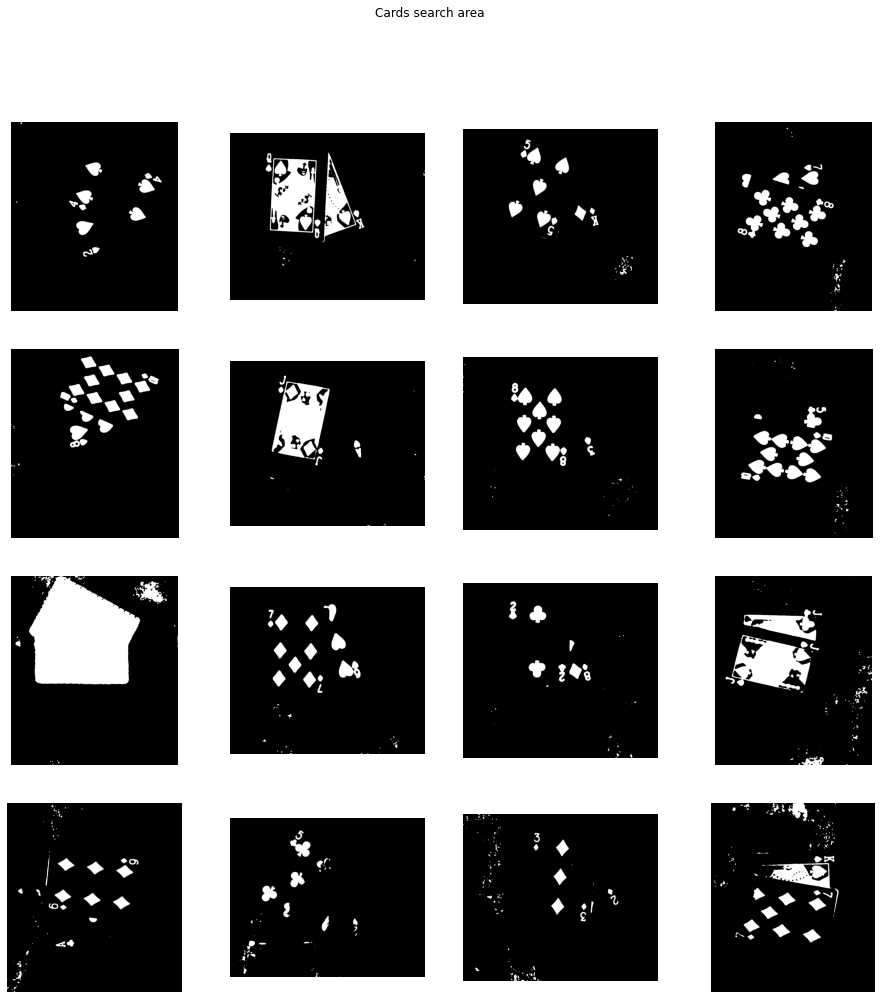

In [213]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize=(16,16))
for area, ax in zip(mod_areas, axes.flatten()):
    ax.imshow(area, cmap = 'gray')
    ax.axis('off')
fig.suptitle('Cards search area')
plt.show()

Use histograms to threshold green channel in procedure

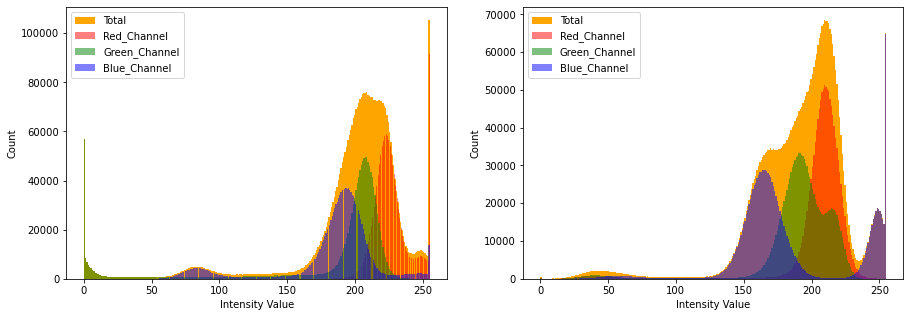

In [128]:
sample = [imgs[0], imgs[3]]
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
for ax, img in zip(axes, sample):
    ax.hist(img.ravel(), bins = 256, color = 'orange', )
    ax.hist(img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    ax.hist(img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
    ax.hist(img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
    ax.set_xlabel('Intensity Value')
    ax.set_ylabel('Count')
    ax.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

## Create card isolation procedure

In [130]:
mod_areas = [isolate_card_feat(img) for img in player_areas]

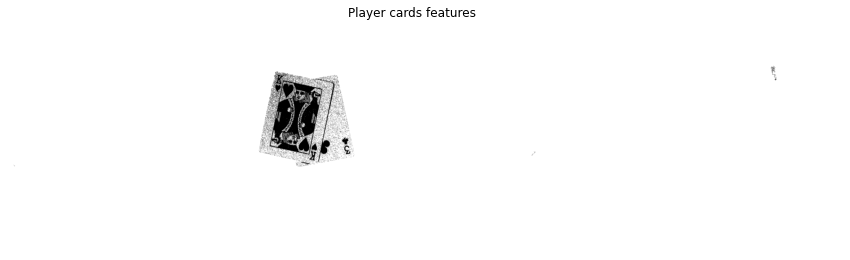

In [131]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(15,4))
for area, ax in zip(mod_areas, axes.flatten()):
    ax.imshow(area, cmap = 'gray')
    ax.axis('off')
fig.suptitle('Player cards features')
plt.show()

In [132]:
# def edge_detector(color_images, cts):
#     final_images = []
#     for image, ct in zip(color_images, cts):
#         x = skimage.color.rgb2gray(image)
#         # smooth for generalization and cleaning
#         #smoothed = filters.gaussian(grayscale, sigma = 1)
#         #x = skimage.filters.unsharp_mask(x, radius = 5)
#         # edge detector
#         x = filters.sobel(x)
        
#         otsu = filters.threshold_otsu(x)
#         x = x > otsu
#         plt.imshow(x, cmap='gray')
#         plt.show()
#         final_images.append(x)
#     return final_images

# def ALL_contours_by_img(img_list):
#     """ 
#     Extracts all contours for each image
#     return: list(  list(contour_1_img_1, ..., contour_m_img_1)  ,  ...,  list(contour_1_img_n, ..., contour_m_img_n)  )
#     """
#     cont_img = []
    
#     #Contours of images
#     for img in img_list:
#         # Compute all contours in image
#         contours, hierarchy = cv.findContours(img.astype(np.uint8) ,cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
        
#         # Case 1: 1 contour detected in image
#         if len(contours) == 1:
#             contour = contours[0][:,0]
#             contour = [contour]
#             # append 1 contour in a list
#             cont_img.append(contour)
            
            
#         # Case 2: more than 1 contour detected
#         else:
#             # append all contours in a list (necessary reshaping)
#             img_contours = [contours[i][:,0] for i in range(len(contours))]
#             cont_img.append(img_contours)
        
#     return cont_img

## try getting good contours with preprocess of player areas

In [191]:
edges = edge_detector(mod_areas)
contours = contours_by_img(edges)
filt_contours = filter_contours_by_size(contours, 69, 310) #value taken from setup_data notebook

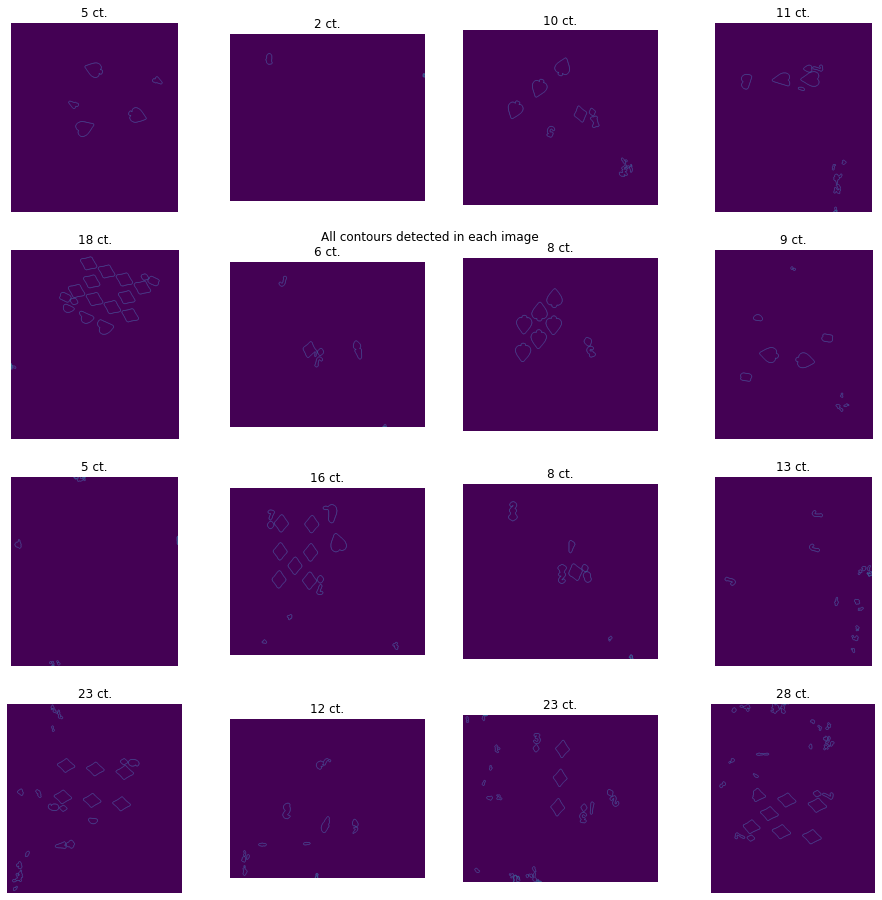

In [192]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize=(16,16))
for ax, contours, image in zip(axes.flatten(), filt_contours, mod_areas):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im)
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
fig.suptitle('All contours detected in each image', y = 0.7)
plt.show()

In [193]:
n = 10
cards_comp_ct = [complex_contours(card_cont) for card_cont in filt_contours]
test_descr = [n_FT_descr(comp_ct, n) for comp_ct in cards_comp_ct]

In [194]:
test_3D_descr = []
for card_descr in test_descr:
    if len(card_descr)!=0:
        descr_1 = card_descr[:,1]
        descr_2 = card_descr[:,2]
        descr_3 = card_descr[:,3]
        descr_4 = card_descr[:,4]
        descr_5 = card_descr[:,5]
        descr_6 = card_descr[:,6]
        descr_7 = card_descr[:,7]
        descr_8 = card_descr[:,8]
        descr_9 = card_descr[:,9]
        card_contours_descr = np.vstack([descr_1,descr_2,descr_3,
                                         descr_4,descr_5,descr_6,
                                        descr_7,descr_8,descr_9]).T
    else: card_contours_descr = np.zeros(9)
    test_3D_descr.append(card_contours_descr)

In [195]:
GT_descr = np.load('GT_descr.npy', allow_pickle = True)

In [196]:
for i in range(16):
    if ((i%4)==0): print(f'card {int(i/4+1)}')
    cards = player_pred(test_3D_descr[i], filt_contours[i], GT_descr, (3-i)%4 +1, number_keys, symbol_keys)
    print(cards)

card 1
['5coeur', '4pique']
['8pique', 'Kpique']
['6pique', 'Kcarreau']
['8coeur', '7coeur']
card 2
['8coeur', '8carreau']
['6carreau', '4coeur']
['8carreau', '6carreau']
['8pique', '8carreau']
card 3
['0', '0']
['4carreau', '8carreau']
['8carreau', '8carreau']
['8coeur', '8pique']
card 4
['4coeur', 'Qcarreau']
['8carreau', '8pique']
['9carreau', '2carreau']
['4carreau', '9carreau']


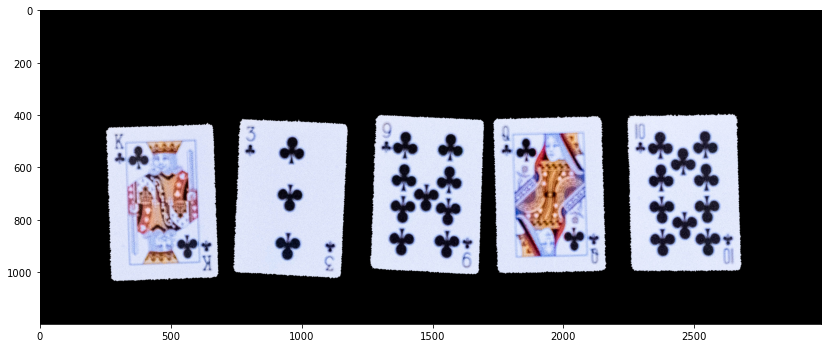

In [390]:
def isolate_common_cards(img):
    x = np.copy(img)
    cond = x[:,:,1] < 222
    x[cond] = 0
    x = skimage.color.rgb2gray(x)
    k = cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
    x = skimage.morphology.binary_opening(x, k)#, footprint=None, out=None)
    k = cv.getStructuringElement(cv.MORPH_CROSS,(6,6))
    x = skimage.morphology.binary_closing(x, k)#, footprint=None, out=None)
    im = np.zeros((x.shape[0], x.shape[1]))
    
    [cts] = contours_by_img([x])
    lengths = [len(ct) for ct in cts]
    idx = np.argsort(lengths)
    cts_of_cards = ([cts[i] for i in idx])[-5:]
    for ct in cts_of_cards:
        im[ct[:,1], ct[:,0]] = 255
    im = nd.binary_fill_holes(im)
    #plt.imshow(im, cmap = 'gray')
    #plt.show()
    return im
    #plt.imshow(x, cmap = 'gray')
mask = isolate_common_cards(common_areas)[..., np.newaxis]
plt.figure(figsize=(14,6))
plt.imshow(mask*common_areas)
plt.show()